In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
np.random.seed(1429)

In [2]:
df=pd.read_csv("Banking.csv")

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [4]:
df["Target"]=df.y

In [5]:
df=df.drop("y", axis=1)

In [6]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
#to find information values strictly for binary response and logistic regression
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [7]:
final_iv, IV = data_vars(df,df.Target)
final_iv

C:\Users\bishw\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,age,17,38,21175,2523,0.119150,18652,0.880850,0.543750,0.510343,0.063407,0.004479
1,age,39,98,20013,2117,0.105781,17896,0.894219,0.456250,0.489657,-0.070665,0.004479
2,job,admin.,admin.,10422,1352,0.129726,9070,0.870274,0.291379,0.248167,0.160525,0.188713
3,job,blue-collar,blue-collar,9254,638,0.068943,8616,0.931057,0.137500,0.235745,-0.539126,0.188713
4,job,entrepreneur,entrepreneur,1456,124,0.085165,1332,0.914835,0.026724,0.036445,-0.310243,0.188713
...,...,...,...,...,...,...,...,...,...,...,...,...
87,cons_conf_idx,-40.8,-26.9,17637,2611,0.148041,15026,0.851959,0.562716,0.411131,0.313863,0.092692
88,euribor3m,0.634,4.857,22055,3626,0.164407,18429,0.835593,0.781466,0.504241,0.438117,0.348544
89,euribor3m,4.858,5.045,19133,1014,0.052997,18119,0.947003,0.218534,0.495759,-0.819146,0.348544
90,nr_employed,4963.6,5191,21271,3542,0.166518,17729,0.833482,0.763362,0.485088,0.453402,0.342518


In [8]:
IV=IV.sort_values("IV",ascending=False)
IV=IV[IV.IV>=0.02]

[Text(0, 0, 'duration'),
 Text(0, 0, 'poutcome'),
 Text(0, 0, 'month'),
 Text(0, 0, 'euribor3m'),
 Text(0, 0, 'nr_employed'),
 Text(0, 0, 'emp_var_rate'),
 Text(0, 0, 'contact'),
 Text(0, 0, 'previous'),
 Text(0, 0, 'job'),
 Text(0, 0, 'default'),
 Text(0, 0, 'cons_price_idx'),
 Text(0, 0, 'cons_conf_idx'),
 Text(0, 0, 'education'),
 Text(0, 0, 'campaign'),
 Text(0, 0, 'marital')]

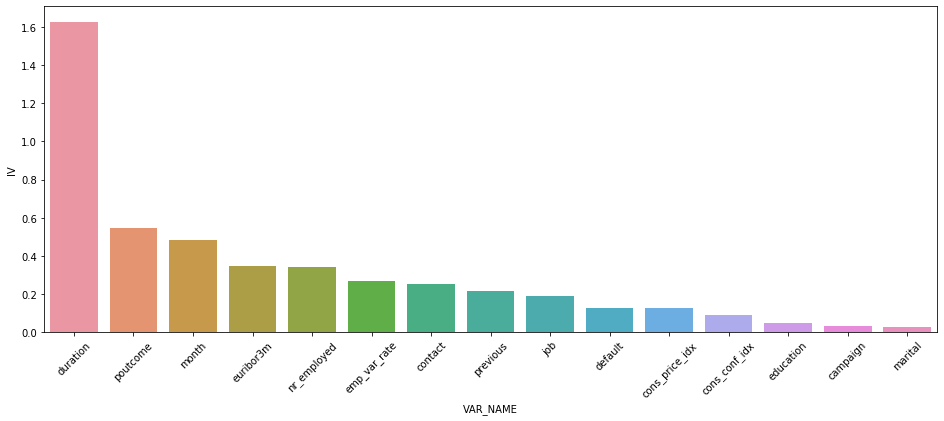

In [9]:
plt.figure(figsize=(16, 6))
ax=sns.barplot(x="VAR_NAME", y="IV",data=IV)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [10]:
IV

,VAR_NAME,IV
7,duration,1.625228
18,poutcome,0.547671
15,month,0.485117
10,euribor3m,0.348544
16,nr_employed,0.342518
9,emp_var_rate,0.269217
4,contact,0.251663
19,previous,0.217318
12,job,0.188713
6,default,0.127769


In [11]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'Target'],
      dtype='object')

In [12]:
df=df.loc[:,['duration',
 'poutcome',
 'month',
 'euribor3m',
 'nr_employed',
 'emp_var_rate',
 'contact',
 'previous',
 'job',
 'default',
 'cons_price_idx',
 'cons_conf_idx',
 'education',
 'campaign',
 'marital','Target']]

In [13]:
list(IV.VAR_NAME)

['duration',
 'poutcome',
 'month',
 'euribor3m',
 'nr_employed',
 'emp_var_rate',
 'contact',
 'previous',
 'job',
 'default',
 'cons_price_idx',
 'cons_conf_idx',
 'education',
 'campaign',
 'marital']

In [14]:
df.head()

,duration,poutcome,month,euribor3m,nr_employed,emp_var_rate,contact,previous,job,default,cons_price_idx,cons_conf_idx,education,campaign,marital,Target
0,210,nonexistent,aug,4.963,5228.1,1.4,cellular,0,blue-collar,unknown,93.444,-36.1,basic.4y,1,married,0
1,138,nonexistent,nov,4.021,5195.8,-0.1,cellular,0,technician,no,93.200,-42.0,unknown,1,married,0
2,339,success,jun,0.729,4991.6,-1.7,cellular,2,management,no,94.055,-39.8,university.degree,3,single,1
3,185,nonexistent,apr,1.405,5099.1,-1.8,cellular,0,services,no,93.075,-47.1,high.school,2,married,0
4,137,success,aug,0.869,5076.2,-2.9,cellular,1,retired,no,92.201,-31.4,basic.4y,1,married,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
duration          41188 non-null int64
poutcome          41188 non-null object
month             41188 non-null object
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
emp_var_rate      41188 non-null float64
contact           41188 non-null object
previous          41188 non-null int64
job               41188 non-null object
default           41188 non-null object
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
education         41188 non-null object
campaign          41188 non-null int64
marital           41188 non-null object
Target            41188 non-null int64
dtypes: float64(5), int64(4), object(7)
memory usage: 5.0+ MB


In [16]:
df.poutcome=df.poutcome.astype('category')
df.month=df.month.astype('category')
df.contact=df.contact.astype('category')
df.previous=df.previous.astype('category')
df.job=df.job.astype('category')
df.default=df.default.astype('category')
df.education=df.education.astype('category')
df.campaign=df.campaign.astype('category')
df.marital=df.marital.astype('category')

In [17]:
df.columns

Index(['duration', 'poutcome', 'month', 'euribor3m', 'nr_employed',
       'emp_var_rate', 'contact', 'previous', 'job', 'default',
       'cons_price_idx', 'cons_conf_idx', 'education', 'campaign', 'marital',
       'Target'],
      dtype='object')

In [18]:
sc=StandardScaler()

In [19]:
dum=pd.get_dummies(df.loc[:,[
 'poutcome',
 'contact',
 'previous',
 'job',
 'default',
 'education',
 'marital',"campaign"]], drop_first=True)

In [20]:
df.drop(labels=["poutcome","month","contact","previous","job","default","education","campaign","marital"], axis=1, inplace=True)

In [21]:
df=pd.concat([df,dum], axis=1)

(6, 0)

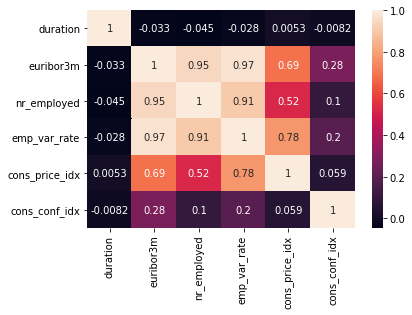

In [22]:
ax=sns.heatmap(df.loc[:,['duration', 'euribor3m', 'nr_employed', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx']].corr(), annot=True)
ax.set_ylim(6,0)

#euribor3m is highly correlated with nr_employed, emp_var_rate
#nr_employed is highly correlated with emp_var_rate
#emp_var_rate also has medium-high correlation with cons_price_idx

In [23]:
X=df.loc[:,['duration', 'euribor3m', 'nr_employed', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx','poutcome_nonexistent',
       'poutcome_success', 'contact_telephone', 'previous_1', 'previous_2',
       'previous_3', 'previous_4', 'previous_5', 'previous_6', 'previous_7',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'default_unknown', 'default_yes', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'campaign_2', 'campaign_3', 'campaign_4',
       'campaign_5', 'campaign_6', 'campaign_7', 'campaign_8', 'campaign_9',
       'campaign_10', 'campaign_11', 'campaign_12', 'campaign_13',
       'campaign_14', 'campaign_15', 'campaign_16', 'campaign_17',
       'campaign_18', 'campaign_19', 'campaign_20', 'campaign_21',
       'campaign_22', 'campaign_23', 'campaign_24', 'campaign_25',
       'campaign_26', 'campaign_27', 'campaign_28', 'campaign_29',
       'campaign_30', 'campaign_31', 'campaign_32', 'campaign_33',
       'campaign_34', 'campaign_35', 'campaign_37', 'campaign_39',
       'campaign_40', 'campaign_41', 'campaign_42', 'campaign_43',
       'campaign_56', 'marital_married', 'marital_single', 'marital_unknown']]
y=df.loc[:,"Target"]

In [24]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1.015515,duration
1,65.792254,euribor3m
2,32.625107,nr_employed
3,39.185979,emp_var_rate
4,9.299639,cons_price_idx
...,...,...
75,1.000433,campaign_43
76,1.000354,campaign_56
77,2.569043,marital_married
78,2.638288,marital_single


In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
print(vif.to_string())

       VIF Factor                       features
0        1.015515                       duration
1       65.792254                      euribor3m
2       32.625107                    nr_employed
3       39.185979                   emp_var_rate
4        9.299639                 cons_price_idx
5        2.927580                  cons_conf_idx
6   551362.626123           poutcome_nonexistent
7        1.470039               poutcome_success
8        2.095137              contact_telephone
9    70697.141923                     previous_1
10   11692.291715                     previous_2
11    3347.009977                     previous_3
12    1084.843280                     previous_4
13     279.646964                     previous_5
14      78.359711                     previous_6
15      16.403970                     previous_7
16       2.406326                job_blue-collar
17       1.137061               job_entrepreneur
18       1.183064                  job_housemaid
19       1.238845   

In [28]:
print(vif.loc[vif["VIF Factor"]<=4,].to_string())

    VIF Factor                       features
0     1.015515                       duration
5     2.927580                  cons_conf_idx
7     1.470039               poutcome_success
8     2.095137              contact_telephone
16    2.406326                job_blue-collar
17    1.137061               job_entrepreneur
18    1.183064                  job_housemaid
19    1.238845                 job_management
20    1.274355                    job_retired
21    1.121426              job_self-employed
22    1.424664                   job_services
23    1.162178                    job_student
24    1.760932                 job_technician
25    1.099958                 job_unemployed
26    1.073774                    job_unknown
27    1.127201                default_unknown
28    1.000918                    default_yes
29    1.502040             education_basic.6y
30    2.220987             education_basic.9y
31    3.357303          education_high.school
32    1.004816           education

In [29]:
list(vif.features)

['duration',
 'euribor3m',
 'nr_employed',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'poutcome_nonexistent',
 'poutcome_success',
 'contact_telephone',
 'previous_1',
 'previous_2',
 'previous_3',
 'previous_4',
 'previous_5',
 'previous_6',
 'previous_7',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'default_unknown',
 'default_yes',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'campaign_2',
 'campaign_3',
 'campaign_4',
 'campaign_5',
 'campaign_6',
 'campaign_7',
 'campaign_8',
 'campaign_9',
 'campaign_10',
 'campaign_11',
 'campaign_12',
 'campaign_13',
 'campaign_14',
 'campaign_15',
 'campaign_16',
 'campaign_17',
 'campaign_18',
 'campaign_19',
 'campaign_20',
 'campaign

In [30]:
X=df.loc[:,['duration',
 'euribor3m',
 'nr_employed',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'poutcome_nonexistent',
 'poutcome_success',
 'contact_telephone',
 'previous_1',
 'previous_2',
 'previous_3',
 'previous_4',
 'previous_5',
 'previous_6',
 'previous_7',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'default_unknown',
 'default_yes',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'campaign_2',
 'campaign_3',
 'campaign_4',
 'campaign_5',
 'campaign_6',
 'campaign_7',
 'campaign_8',
 'campaign_9',
 'campaign_10',
 'campaign_11',
 'campaign_12',
 'campaign_13',
 'campaign_14',
 'campaign_15',
 'campaign_16',
 'campaign_17',
 'campaign_18',
 'campaign_19',
 'campaign_20',
 'campaign_21',
 'campaign_22',
 'campaign_23',
 'campaign_24',
 'campaign_25',
 'campaign_26',
 'campaign_27',
 'campaign_28',
 'campaign_29',
 'campaign_30',
 'campaign_31',
 'campaign_32',
 'campaign_33',
 'campaign_34',
 'campaign_35',
 'campaign_37',
 'campaign_39',
 'campaign_40',
 'campaign_41',
 'campaign_42',
 'campaign_43',
 'campaign_56',
 'marital_married',
 'marital_single',
 'marital_unknown']]
y=df.loc[:,"Target"]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1429)

In [32]:
X_train_skl=sc.fit_transform(X_train)
X_test_skl=sc.fit_transform(X_test)

In [33]:
glm=LogisticRegression()

In [34]:
glm.fit(X_train_skl, y_train)

C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
Pred=glm.predict(X_test)

In [36]:
from sklearn import metrics

In [37]:
print(metrics.confusion_matrix(y_test, Pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(glm.score(X_test_skl, y_test)))

[[10708   272]
 [ 1062   315]]
Accuracy of logistic regression classifier on test set: 0.91


In [38]:
print(metrics.classification_report(y_test, Pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10980
           1       0.54      0.23      0.32      1377

    accuracy                           0.89     12357
   macro avg       0.72      0.60      0.63     12357
weighted avg       0.87      0.89      0.87     12357



In [39]:
AUC=metrics.roc_auc_score(y_test, Pred)
print("Area under curve {:.2f}". format(AUC))

Area under curve 0.60


In [40]:
fpr, tpr, th=metrics.roc_curve(y_test,glm.predict_proba(X_test_skl)[:,1] )

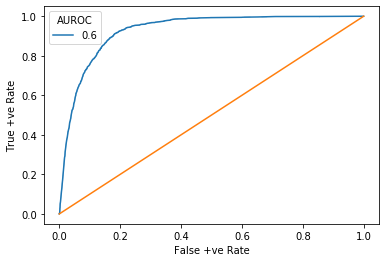

In [41]:
sns.lineplot(fpr,tpr)
sns.lineplot([0,1], [0,1])
plt.xlabel("False +ve Rate")
plt.ylabel("True +ve Rate")
plt.legend(title='AUROC', labels=[np.round(AUC,2)])

array([[10708,   272],
       [ 1062,   315]], dtype=int64)

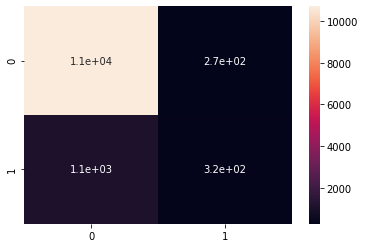

In [42]:
cm=metrics.confusion_matrix(y_test, Pred)
sns.heatmap(cm, annot=True)
plt.ylim(2,0)
cm

In [43]:
precisions, recalls, thresholds =metrics.precision_recall_curve(y_test,glm.predict_proba(X_test)[:,1] )

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [44]:
from sklearn.model_selection import cross_val_score

In [45]:
cv_accuracy=cross_val_score(glm,X_train_skl, y_train, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
print(cv_accuracy)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.7s remaining:    5.1s


[0.91400832 0.90984743 0.90533981 0.90738814 0.9157128  0.91016302
 0.91155047 0.91432536 0.90423317 0.91464261]


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.1s finished


In [46]:
from sklearn.metrics import balanced_accuracy_score

In [47]:
print("Balanced Accuracy Score is {: .2f}".format(balanced_accuracy_score(y_test, Pred)))

Balanced Accuracy Score is  0.60


In [48]:
from sklearn.utils import resample

Oversampling Minority Class, Undersamlping Majority Class, SMOTE(Synthetic Minority Oversampling Technique.)

In [49]:
df_train=pd.concat([X_train, y_train], axis=1)

In [50]:
df_train.Target.value_counts()

0    25568
1     3263
Name: Target, dtype: int64

Zeros majority class and ones are minority class

In [51]:
zero=df_train.loc[df_train.Target==0,:]
one=df_train.loc[df_train.Target==1,:]

In [52]:
ones_upsampled=resample(one, replace=True, n_samples=len(zero), random_state=1429)

In [53]:
zero.shape

(25568, 81)

In [54]:
ones_upsampled.shape

(25568, 81)

In [55]:
df_train_up=pd.concat([zero, ones_upsampled], axis='rows')

In [56]:
zero_downsampled=resample(zero, replace=False, n_samples=len(one), random_state=1429)

In [57]:
zero_downsampled.shape

(3263, 81)

In [58]:
one.shape

(3263, 81)

In [59]:
df_train_down=pd.concat([zero_downsampled, one], axis='rows')

In [60]:
df_train_down.shape

(6526, 81)

In [61]:
from imblearn.over_sampling import SMOTE

In [62]:
sm=SMOTE(random_state=1429, ratio=1, n_jobs=-1)

In [63]:
X_sm_train, y_sm_train = sm.fit_sample(X_train, y_train)

In [64]:
X_sm_train.shape

(51136, 80)

In [65]:
y_sm_train.shape

(51136,)

In [66]:
X_up_train=df_train_up.loc[:,['duration',
 'euribor3m',
 'nr_employed',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'poutcome_nonexistent',
 'poutcome_success',
 'contact_telephone',
 'previous_1',
 'previous_2',
 'previous_3',
 'previous_4',
 'previous_5',
 'previous_6',
 'previous_7',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'default_unknown',
 'default_yes',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'campaign_2',
 'campaign_3',
 'campaign_4',
 'campaign_5',
 'campaign_6',
 'campaign_7',
 'campaign_8',
 'campaign_9',
 'campaign_10',
 'campaign_11',
 'campaign_12',
 'campaign_13',
 'campaign_14',
 'campaign_15',
 'campaign_16',
 'campaign_17',
 'campaign_18',
 'campaign_19',
 'campaign_20',
 'campaign_21',
 'campaign_22',
 'campaign_23',
 'campaign_24',
 'campaign_25',
 'campaign_26',
 'campaign_27',
 'campaign_28',
 'campaign_29',
 'campaign_30',
 'campaign_31',
 'campaign_32',
 'campaign_33',
 'campaign_34',
 'campaign_35',
 'campaign_37',
 'campaign_39',
 'campaign_40',
 'campaign_41',
 'campaign_42',
 'campaign_43',
 'campaign_56',
 'marital_married',
 'marital_single',
 'marital_unknown']]
y_up_train=df_train_up.loc[:,'Target']

In [67]:
X_up_train_skl=sc.fit_transform(X_up_train)

In [68]:
cross_val_score(glm,X_up_train_skl, y_up_train, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.4s finished


array([0.85647243, 0.85705905, 0.85686351, 0.86272976, 0.85549472,
       0.85432147, 0.85099726, 0.85862339, 0.85739437, 0.85582942])

In [69]:
cross_val_score(glm,X_up_train_skl, y_up_train, cv=10, scoring='precision', verbose=1, n_jobs=-1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.5s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.3s finished


array([0.85984998, 0.85803922, 0.85381931, 0.86587771, 0.85232558,
       0.84712644, 0.85127202, 0.85820312, 0.86007095, 0.85680659])

In [70]:
cross_val_score(glm,X_up_train_skl, y_up_train, cv=10, scoring='recall', verbose=1, n_jobs=-1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.3s finished


array([0.85177943, 0.85569026, 0.86116543, 0.85842785, 0.85999218,
       0.86468518, 0.85060618, 0.85921001, 0.85367762, 0.85446009])

In [71]:
glm.fit(X_up_train_skl, y_up_train)

C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
pred_up=glm.predict(X_test)

In [73]:
print(metrics.classification_report(y_test,pred_up))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10980
           1       0.54      0.02      0.04      1377

    accuracy                           0.89     12357
   macro avg       0.71      0.51      0.49     12357
weighted avg       0.85      0.89      0.84     12357



In [74]:
X_down_train=df_train_down.loc[:,['duration',
 'euribor3m',
 'nr_employed',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'poutcome_nonexistent',
 'poutcome_success',
 'contact_telephone',
 'previous_1',
 'previous_2',
 'previous_3',
 'previous_4',
 'previous_5',
 'previous_6',
 'previous_7',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'default_unknown',
 'default_yes',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'campaign_2',
 'campaign_3',
 'campaign_4',
 'campaign_5',
 'campaign_6',
 'campaign_7',
 'campaign_8',
 'campaign_9',
 'campaign_10',
 'campaign_11',
 'campaign_12',
 'campaign_13',
 'campaign_14',
 'campaign_15',
 'campaign_16',
 'campaign_17',
 'campaign_18',
 'campaign_19',
 'campaign_20',
 'campaign_21',
 'campaign_22',
 'campaign_23',
 'campaign_24',
 'campaign_25',
 'campaign_26',
 'campaign_27',
 'campaign_28',
 'campaign_29',
 'campaign_30',
 'campaign_31',
 'campaign_32',
 'campaign_33',
 'campaign_34',
 'campaign_35',
 'campaign_37',
 'campaign_39',
 'campaign_40',
 'campaign_41',
 'campaign_42',
 'campaign_43',
 'campaign_56',
 'marital_married',
 'marital_single',
 'marital_unknown']]
y_down_train=df_train_down.loc[:,'Target']

In [75]:
X_down_train_skl=sc.fit_transform(X_down_train)

In [76]:
cross_val_score(glm,X_down_train_skl, y_down_train, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


array([0.84097859, 0.85015291, 0.84250765, 0.85582822, 0.86042945,
       0.83895706, 0.86656442, 0.86656442, 0.85429448, 0.83588957])

In [77]:
glm.fit(X_down_train_skl,y_down_train)

C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [78]:
pred_down=glm.predict(X_test)

In [79]:
print(metrics.classification_report(y_test, pred_down))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10980
           1       0.57      0.02      0.04      1377

    accuracy                           0.89     12357
   macro avg       0.73      0.51      0.49     12357
weighted avg       0.85      0.89      0.84     12357



In [80]:
df_train_up.Target.value_counts()

1    25568
0    25568
Name: Target, dtype: int64

In [81]:
df_train_down.Target.value_counts()

1    3263
0    3263
Name: Target, dtype: int64

In [82]:
y_test.value_counts()

0    10980
1     1377
Name: Target, dtype: int64

In [83]:
X_sm_train_skl=sc.fit_transform(X_sm_train)

In [84]:
cross_val_score(glm,X_sm_train, y_sm_train, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


array([0.85940555, 0.86077434, 0.86312084, 0.8676183 , 0.86155651,
       0.86214314, 0.85979664, 0.86253422, 0.86287167, 0.86561033])

In [85]:
glm.fit(X_sm_train_skl, y_sm_train)

C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
pred_sm=glm.predict(X_test)

In [87]:
print(metrics.classification_report(y_test, pred_sm))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10980
           1       0.56      0.13      0.21      1377

    accuracy                           0.89     12357
   macro avg       0.73      0.56      0.57     12357
weighted avg       0.86      0.89      0.86     12357



In [90]:
rfe = RFE(glm, 20)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[False  True False  True False False  True  True  True  True False  True
 False False False False  True  True False False  True False  True  True
 False False False  True False False  True False False False  True  True
 False False False  True  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False]
[17  1 10  1  6  3  1  1  1  1  9  1 13 18 25 38  1  1 34 20  1 14  1  1
 16 12 23  1 51  5  1  4 26  7  1  1 15  2 11  1  1  1 19 46 24 22 21 35
 31 45 27 29 32 28 37 39 36 33 40 47 30 44 42 43 48 49 53 55 56 50 61 59
 58 60 52 57 54  8  1 41]


In [94]:
from sklearn.feature_selection import RFE

In [97]:
temp = pd.Series(rfe.support_,index = X.columns)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['euribor3m', 'emp_var_rate', 'poutcome_nonexistent', 'poutcome_success',
       'contact_telephone', 'previous_1', 'previous_3', 'job_blue-collar',
       'job_entrepreneur', 'job_retired', 'job_services', 'job_student',
       'default_unknown', 'education_basic.9y', 'education_university.degree',
       'education_unknown', 'campaign_5', 'campaign_6', 'campaign_7',
       'marital_single'],
      dtype='object')
